In [1]:
import os
import sys
if os.getenv("ORCA_PATH"):
    ORCA_PATH = os.getenv("ORCA_PATH")
else:
    # change this to the right path if you use a different path
    # or specify the ORCA_PATH environmental variable
    ORCA_PATH = "../orca"
sys.path.append(ORCA_PATH)

In [2]:
import orca_predict 
orca_predict.load_resources(models=['1M'],use_cuda=True)
from orca_predict import *

In [3]:
sequence = hg38.get_encoding_from_coords('chr10',117350000-500000, 117350000+500000 )[None,:,:]

In [4]:
import time

def pred_1m(seq, model):
    pred = model.net.forward(seq.transpose(1,2))
    if isinstance(pred, tuple):
        pred, _ = pred
    return pred

np.random.seed(321)

with torch.no_grad():
    pred = pred_1m(torch.FloatTensor(sequence).cuda(),h1esc_1m).squeeze().detach().cpu().numpy()
    alldiffs = []
    for _ in range(5):
        diffs_ = []
        st = time.time()
        for i in range(10000,90000):
            sequence_mut = sequence.copy()
            sequence_mut[0,i*10:(i+1)*10,:]=sequence[0,np.random.randint(0,sequence.shape[1],10),:]
            pred_mut = pred_1m(torch.FloatTensor(sequence_mut).cuda(), h1esc_1m).squeeze().detach().cpu().numpy()
            diff = np.mean(np.abs(pred_mut[int(np.floor(i/400)),:]-pred[int(np.floor(i/400)),:]))
            diffs_.append(diff)
        alldiffs.append(diffs_)

    print(time.time()-st)



<PYTHONPATH>/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


8836.414727449417


In [5]:
np.random.seed(123)
alldiffs_multiplex = []
for _ in range(5):
    basedesign =  np.arange(10000,90000).reshape(20,4000)
    for i in range(basedesign.shape[0]):
        basedesign[i,:] = basedesign[i,np.random.permutation(4000)]

    with torch.no_grad():
        pred = pred_1m(torch.FloatTensor(sequence).cuda(),h1esc_1m).squeeze().detach().cpu().numpy()
        diffsrand = np.ones(100000) 
        for j in range(basedesign.shape[1]):
            sequence_mut = sequence.copy()
            for i in basedesign[:,j]:
                sequence_mut[0,i*10:(i+1)*10,:]=sequence[0,np.random.randint(0,sequence.shape[1],10),:]
            pred_mut = pred_1m(torch.FloatTensor(sequence_mut).cuda(),h1esc_1m).squeeze().detach().cpu().numpy()
            diffsrand[basedesign[:,j]] = np.mean(np.abs(pred_mut[np.floor(basedesign[:,j]/400).astype(int),:]-pred[np.floor(basedesign[:,j]/400).astype(int),:]),axis=1)
    alldiffs_multiplex.append(diffsrand[10000:90000])

In [6]:
import pandas as pd
from scipy.stats import pearsonr
plotdata = pd.DataFrame({'d0':alldiffs[0], 'd1': alldiffs[1], 'd2': alldiffs[2], 'd3': alldiffs[3], 'd4': alldiffs[4],
                         'dm0': alldiffs_multiplex[0], 'dm1': alldiffs_multiplex[1], 'dm2': alldiffs_multiplex[2],
                        'dm3': alldiffs_multiplex[3], 'dm4': alldiffs_multiplex[4]})

cors = []
for i in range(1,6):
    cors.append(pearsonr(np.min(alldiffs[:i],axis=0), np.min(alldiffs_multiplex[:i],axis=0))[0])
cors

[0.5919578479503855,
 0.8751832490921496,
 0.907921618070891,
 0.9114165336034727,
 0.9215051063274992]

In [7]:
torch.save({'alldiffs':alldiffs,'alldiffs_multiplex':alldiffs_multiplex},'./figure_data/mism_demo.pth')

In [8]:
%load_ext rpy2.ipython

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: patchwork

R[write to console]: Saving 10 x 5 in image



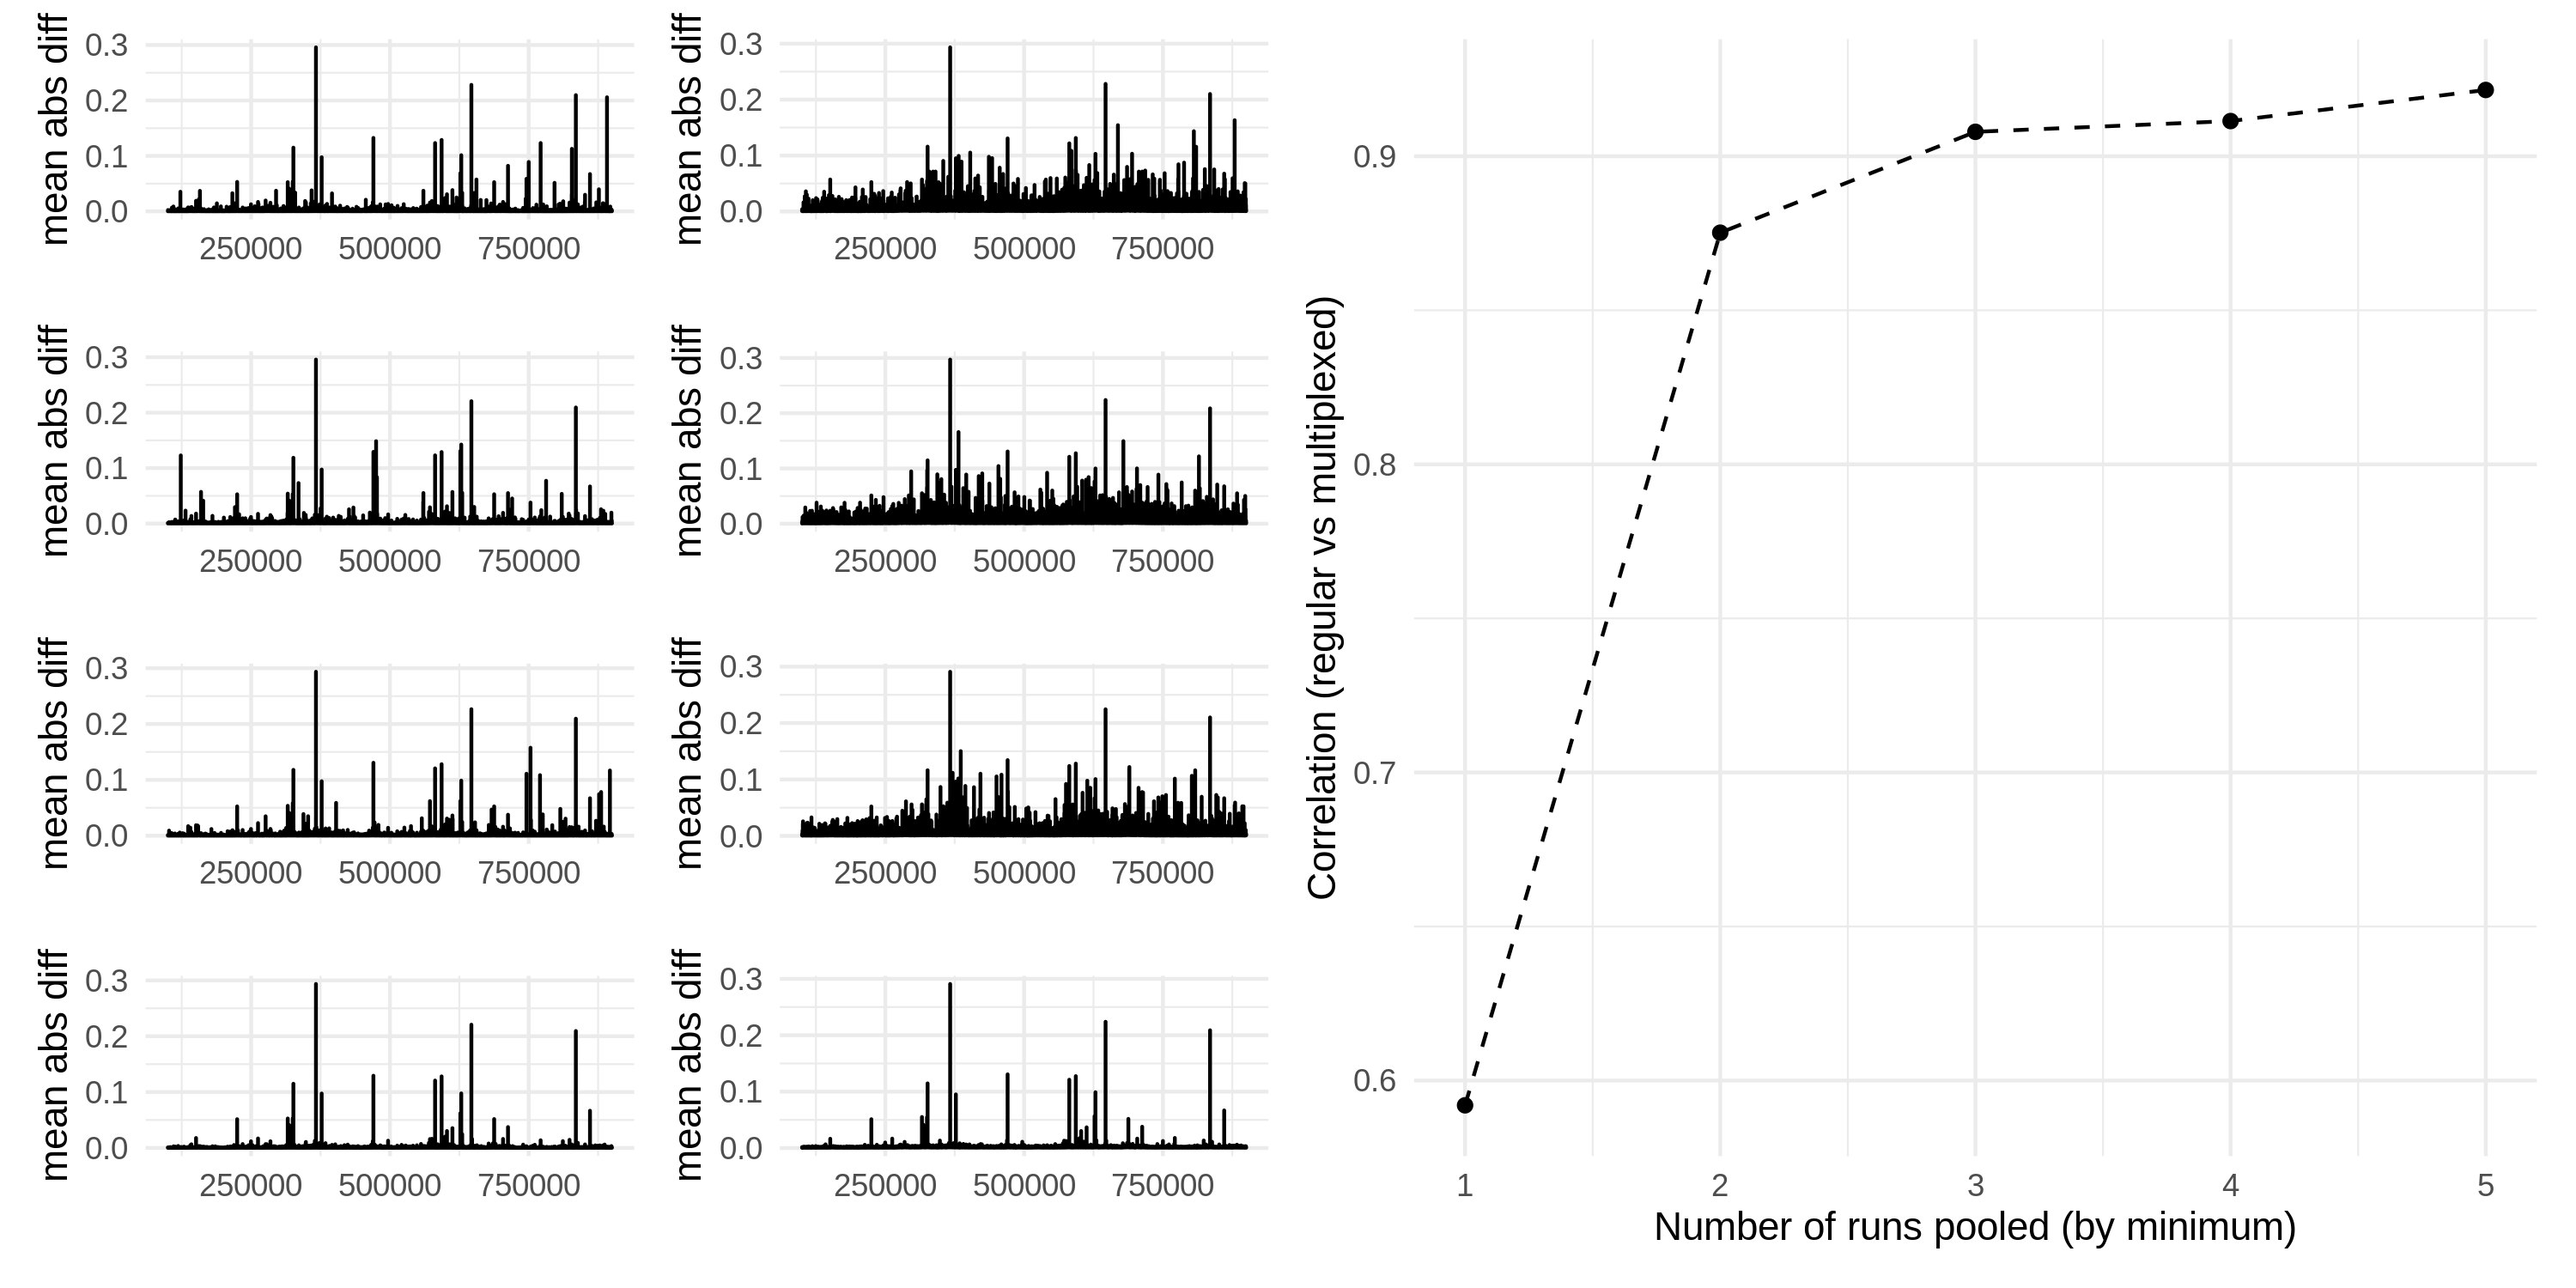

In [9]:
%%R -i plotdata,cors -w 10 -h 5 --units in -r 300

require(ggplot2)
require(patchwork)
p1 = qplot(10*(10001:90000)-10,plotdata$d0, geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()
p2 = qplot(10*(10001:90000)-10,plotdata$d1, geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()
p3 = qplot(10*(10001:90000)-10,plotdata$d2, geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()
p21 = qplot(10*(10001:90000)-10,plotdata$dm0, geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()
p22 = qplot(10*(10001:90000)-10,plotdata$dm1, geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()
p23 = qplot(10*(10001:90000)-10,plotdata$dm2, geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()

q1 = qplot(10*(10001:90000)-10,pmin(plotdata$d0,plotdata$d1,plotdata$d2), geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()
q2 = qplot(10*(10001:90000)-10,pmin(plotdata$dm0,plotdata$dm1,plotdata$dm2), geom='line')+ylab('mean abs diff')+xlab('')+theme_minimal()

r = ggplot()+geom_line(aes(1:5, unlist(cors)),linetype=2)+geom_point(aes(1:5, unlist(cors)))+
 xlab('Number of runs pooled (by minimum)')+ylab('Correlation (regular vs multiplexed)')+theme_minimal()

((p1+p21) / (p2 + p22) /(p3 + p23)  / (q1+q2) ) | r 

ggsave('./figures/local_motif_multiplex.demo.pdf')
((p1+p21) / (p2 + p22) /(p3 + p23)  / (q1+q2) ) | r 
